In [6]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 
from colorml.kl_anneal import monotonical_kl_anneal
from functools import partial

from sklearn.gaussian_process import GaussianProcessRegressor
import probflow as pf
from probflow.callbacks import MonitorELBO, MonitorMetric, EarlyStopping, KLWeightScheduler

RESULTS = os.path.join('..', 'results', 'baselines')
MODELS = os.path.join('..', 'models', 'baselines')
from numpy.random import seed
seed(821996)

CHEMICAL_FEATURES = metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors + mol_desc  + summed_linker_descriptors + summed_metalcenter_descriptors + summed_functionalgroup_descriptors

In [2]:
def mapping_to_target_range(x, target_min=0, target_max=1):
    """Linear activation function that constrains output to a range
    
    Arguments:
        x {tensor} -- input tensor
    
    Keyword Arguments:
        target_min {float} -- minimum output (default: {0})
        target_max {float} -- maximum output (default: {1})
    
    Returns:
        tensor -- constrained linear activation
    """
    x02 = x + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.0
    return x02 * scale + target_min

In [4]:
import tensorflow_addons as tfa
 
class DenseNetwork2(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [mapping_to_target_range]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [326]:
import tensorflow_addons as tfa
 
class DenseNetwork(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [lambda x: x]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [75]:
df_subset_merged = pd.read_csv('../data/color_feat_merged.csv')

In [76]:
augment_dict = read_pickle('../data/augment_dict.pkl')

In [77]:
df_train, df_test = train_test_split(df_subset_merged, train_size=0.7)

In [78]:
df_train = augment_data(df_train, augment_dict)

In [79]:
X_train = df_train[CHEMICAL_FEATURES]
y_train = df_train[['r', 'g', 'b']]

X_test = df_test[CHEMICAL_FEATURES]
y_test = df_test[['r', 'g', 'b']]

In [80]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [81]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
X_test, X_valid, y_test, y_valid, names_valid, names_valid = train_test_split(X_test, y_test, names_test, train_size=0.9)

In [83]:
y_train = y_train / 255
y_valid = y_valid / 255
y_test = y_test / 255

In [39]:
class DensityNetwork(pf.ContinuousModel):

    def __init__(self, units, head_units):
        self.core = DenseNetwork(units)
        self.mean = DenseNetwork2(head_units)
        self.std  = DenseNetwork2(head_units)
        self.batch_norm = pf.modules.BatchNormalization([units[-1]])
        
    def __call__(self, x):
        x = self.core(x)
        x = self.batch_norm(x)
        return pf.Cauchy(self.mean(x), tf.exp(self.std(x)))

# Create the model
model = DensityNetwork([X_train.shape[1], 32, 16], [16, 8, 3])

monitor_mae = MonitorMetric('mae', X_valid, y_valid, verbose=True)
monitor_elbo = MonitorELBO()
early_stopping = EarlyStopping(lambda: monitor_mae.current_metric, patience=30)

kl_annealer = KLWeightScheduler(
                    partial(monotonical_kl_anneal, M=50)
                )


# Fit it!
model.fit(X_train, y_train, callbacks=[monitor_mae, monitor_elbo, early_stopping], batch_size=50, epochs=500, lr=3e-3)

Epoch 1 	mae: 0.39508048732818063
Epoch 2 	mae: 0.3902621831615341
Epoch 3 	mae: 0.3440725904110259
Epoch 4 	mae: 0.3357827787588408
Epoch 5 	mae: 0.32812215465022704
Epoch 6 	mae: 0.3098881934282486
Epoch 7 	mae: 0.30022094833841123
Epoch 8 	mae: 0.3033305032397894
Epoch 9 	mae: 0.2924078739835184
Epoch 10 	mae: 0.2853514684721598
Epoch 11 	mae: 0.27950416996163757
Epoch 12 	mae: 0.26988936979436673
Epoch 13 	mae: 0.26552678070141544
Epoch 14 	mae: 0.264119867510558
Epoch 15 	mae: 0.26094023684104056
Epoch 16 	mae: 0.255646897983206
Epoch 17 	mae: 0.2481316949565217
Epoch 18 	mae: 0.23904387430121807
Epoch 19 	mae: 0.23910977332874522
Epoch 20 	mae: 0.23601158379318837
Epoch 21 	mae: 0.23449118462479027
Epoch 22 	mae: 0.23227654557064678
Epoch 23 	mae: 0.22883880929612704
Epoch 24 	mae: 0.2306041849257962
Epoch 25 	mae: 0.2278019873514062
Epoch 26 	mae: 0.22863611851816254
Epoch 27 	mae: 0.23113088416880004
Epoch 28 	mae: 0.22918323191129766
Epoch 29 	mae: 0.22637262594582644
Epoch 30

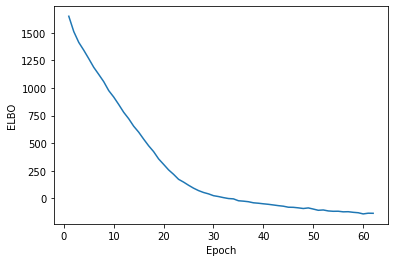

In [40]:
monitor_elbo.plot()

../colorml/utils.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


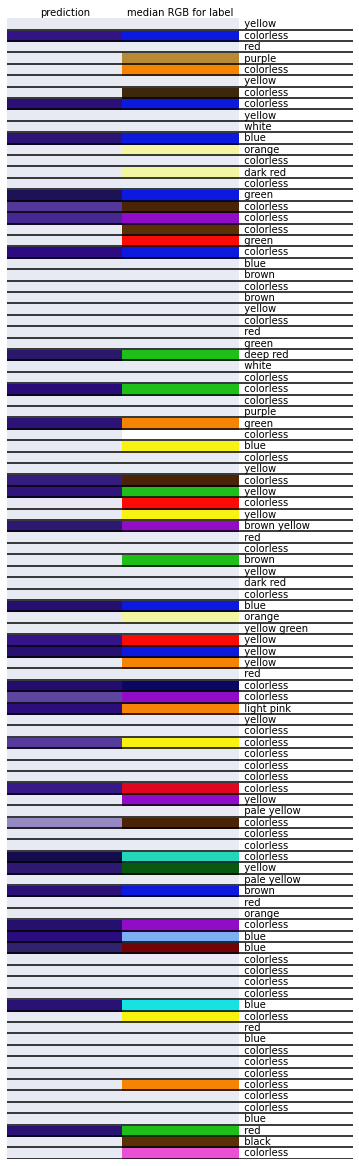

In [41]:
predictions = model.predict(X_train)

plot_predictions(predictions * 255, y_train.values * 255,  name_train.values,  sample=100)

## Trying to use dropout as a measure of uncertainity

https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras

https://www.reddit.com/r/MachineLearning/comments/7bm4b2/d_what_is_the_current_state_of_dropout_as/

In [26]:
import tensorflow as tf
from keras.layers import Dropout, Dense, BatchNormalization, GaussianDropout, GaussianNoise, LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from livelossplot.keras import PlotLossesCallback
from keras.constraints import MinMaxNorm
from keras.initializers import Constant
from keras.optimizers import Adam
from colorml.utils import mapping_to_target_range, read_pickle, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig
from livelossplot.keras import PlotLossesCallback

In [300]:
timestamp = get_timestamp_string()
mlp = Sequential()
mlp.add(Dense(64, activation="relu", 
              kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32,  activation="relu", 
             kernel_initializer='he_normal'))  
mlp.add(Dropout(0.2))
mlp.add(Dense(16,  activation="relu", 
             kernel_initializer='he_normal'))  
mlp.add(Dropout(0.2))
mlp.add(Dense(8,  activation='relu', 
             kernel_initializer='he_normal'))
mlp.add(Dropout(0.2))
mlp.add(Dense(3, activation=mapping_to_target_range, kernel_initializer='he_normal'))


In [301]:
mlp.compile(optimizer=Adam(learning_rate=3e-3), loss=huber_fn, metrics=['mae', 'mean_absolute_percentage_error'])

In [302]:
es = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

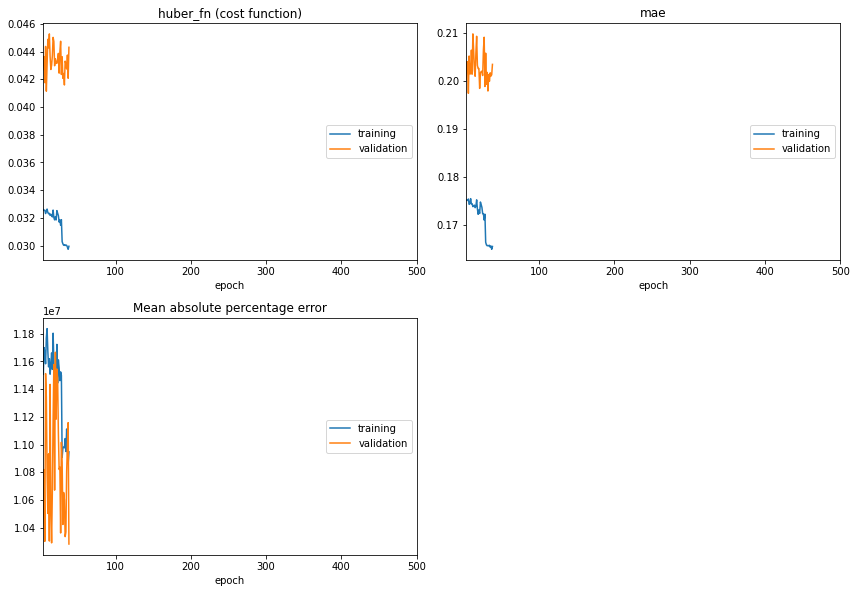

In [311]:
mlp.fit(X_train, y_train, epochs=500, batch_size=264, callbacks=[es, PlotLossesCallback(plot_extrema=False), learning_rate_reduction], validation_data=(X_valid, y_valid))

In [327]:
import keras.backend as K
f = K.function([mlp.layers[0].input, K.learning_phase()],
               [mlp.layers[-1].output])

In [328]:
def predict_with_uncertainty(f, x, n_iter=1000):
    result = []

    for i in range(n_iter):
        result.append(f([x, 1]))

    result = np.array(result)

    prediction = np.median(result, axis=0)
    uncertainty = result.var(axis=0)
    return result, prediction, uncertainty

In [329]:
result, rediction, uncertainity = predict_with_uncertainty(f, X_train[:100])

In [330]:
def rgb_to_hex_round(c): 
    return rgb_to_hex((int(c[0]), int(c[1]), int(c[2])))

In [331]:
from webcolors import rgb_to_hex

def plot_prediction_dist(predictions_dist, label_names, label_dict, sample=100, outname=None, centrality='median', n_samples=10, width=0.2, figsize=(8.16)):
    """Plot figure that compares color of predictions versus acutal colors.
    
    Arguments:
        predictions {iterable} -- iterable of rgb colors
        labels {iterable} -- iterable of rgb colors
    
    Keyword Arguments:
        sample {int} -- how many samples to plot (default: {100})
        outname {string} -- path to which figure is saved (default: {None})
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    predictions = predictions_dist[:, 0, :sample]
    label_names = label_names.values[:sample]
    label_names_set = set(label_names)
    
   
        
    if centrality == 'median': 
        prediction_centrality = np.median(predictions, axis=0)
        label_centrality_dict = {}
        for color in label_names_set: 
            label_centrality_dict[color] = np.median(label_dict[color], axis=0)

    for i in range(len(label_names)):
        colorname = label_names[i]
        r1 = mpatch.Rectangle((0, i), 1, 1, color=rgb_to_hex_round(prediction_centrality[i]))
        r2 = mpatch.Rectangle((1, i), 1, 1, color=rgb_to_hex_round(label_centrality_dict[colorname]))

        ax.add_patch(r1)
        ax.add_patch(r2)
        
        for j in range(n_samples):
            choice = np.random.randint(0,len(predictions_dist))
            choice2 = np.random.randint(0, len(label_dict[colorname]))
            r3 = mpatch.Rectangle((-0.5 - width * j, i), 0.5, 1, color=rgb_to_hex_round(
                predictions[choice][i]
            ))
            r4 = mpatch.Rectangle((2 + width * j, i), 0.5, 1, color=rgb_to_hex_round(
               label_dict[colorname][choice2]
            ))
            ax.add_patch(r3)
            ax.add_patch(r4)
        
        ax.axhline(i, color="k")

    ax.text(0.5, i + 1.5, "prediction {}".format(centrality), ha="center", va="center")
    ax.text(1.5, i + 1.5, "label {}".format(centrality), ha="center", va="center")
    
    ax.text(0.5 - n_samples * 3/4 * width, i + 1.5, "prediction samples", ha="center", va="center")
    ax.text(1.5 + n_samples * 3/4 * width, i + 1.5, "colorjeopardy samples", ha="center", va="center")
    
    ax.set_xlim(0 - n_samples * width, 2 + n_samples * width)
    ax.set_ylim(0, i + 2)
    ax.axis("off")

    fig.tight_layout()

    if outname is not None:
        fig.savefig(outname, bbox_inches="tight")


In [332]:
result.shape

(1000, 1, 100, 3)

In [333]:
plot_prediction_dist(result * 255, name_train, augment_dict)

TypeError: from_bounds() argument after * must be an iterable, not float